#### 多種模型預測

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef,confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import svm, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
control=pd.read_csv("../result/Control_Male.csv")
training=pd.read_csv("../result/Training_Male.csv")

# control=pd.read_csv("../result/Control_Female.csv")
# training=pd.read_csv("../result/Training_Female.csv")

print(control.shape)
print(training.shape)

(2774, 158)
(1316, 158)


In [3]:
features = pd.concat([control,training],ignore_index=True)
features = features.drop(columns=['TWB2_ID','I_32','Label'])

#將ID排除
X = features.iloc[:,1::]
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=pd.concat([control_label,training_label],ignore_index=True)
label_encoder = LabelEncoder()
y = list(label_encoder.fit_transform(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Columns: 154 entries, AGE to MICROALB
dtypes: float64(154)
memory usage: 4.8 MB
None
樣本數:  4090


In [9]:
# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 3681
測試集樣本數量： 409
訓練集中各類別樣本數量：
Counter({0: 2486, 1: 1195})
測試集中各類別樣本數量：
Counter({0: 288, 1: 121})


In [10]:
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print('SMOTE train set sampling:')
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_train, y_train)
print('BSMOTE train set sampling:')
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val,y_val)
print('Random sampling:')
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val,y_val)
print('SMOTE test set sampling:')
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val,y_val)
print('BSMOTE test set sampling:')
print(Counter(bsmote_test_Y))

# Male
X_train, y_train = smote_train_X, smote_train_Y
X_val, y_val = smote_test_X, smote_test_Y

# Female
# X_train, y_train = smote_train_X, smote_train_Y
# y_val, y_val = bsmote_test_X, bsmote_test_Y

SMOTE train set sampling:
Counter({0: 2486, 1: 2486})
BSMOTE train set sampling:
Counter({0: 2486, 1: 2486})
Random sampling:
Counter({0: 121, 1: 121})
SMOTE test set sampling:
Counter({0: 288, 1: 288})
BSMOTE test set sampling:
Counter({0: 288, 1: 288})


In [11]:
def plot_confusion_matrix(confusion):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])
    cm_display.plot()
    plt.show()

def evalution_metrics(test_label, labels_score, txt_name, save=True, path = '../result/'):
    accuracy = accuracy_score(test_label, labels_score.round())
    confusion =  confusion_matrix(test_label, labels_score.round())
    plot_confusion_matrix(confusion)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_label, labels_score.round())
    mcc = matthews_corrcoef(test_label, labels_score.round())
    
    metrics = np.round([TP, TN, FP, FN, accuracy, precision, sensitivity, specificity, f1, mcc],2)
    columns=['TP', 'TN', 'FP', 'FN', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1', 'mcc']
    metrics_dict = dict(zip(columns,metrics))
    
    if save:
        df = pd.DataFrame(metrics_dict,index=[0])
        df.to_csv(path+'%s_metrics.csv'%txt_name)
        print('TP: %f' % TP+'\n')
        print('TN: %f' % TN+'\n')
        print('FP: %f' % FP+'\n')
        print('FN: %f' % FN+'\n')
        print('Accuracy: %f' % accuracy+'\n')
        print('Precision: %f' % precision+'\n')  
        print('Sensitivity/Recall: %f' % sensitivity+'\n')
        print('Specificity: %f' %specificity+'\n')
        print('F1 score: %f' % f1+'\n')
        print('Matthews Corrcoef:%f' % mcc+'\n')
    else:
        return(metrics_dict)

#### XGBoost

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 20, 'n_estimators': 100, 'subsample': 0.7}
Best Score: 0.7627382384760826


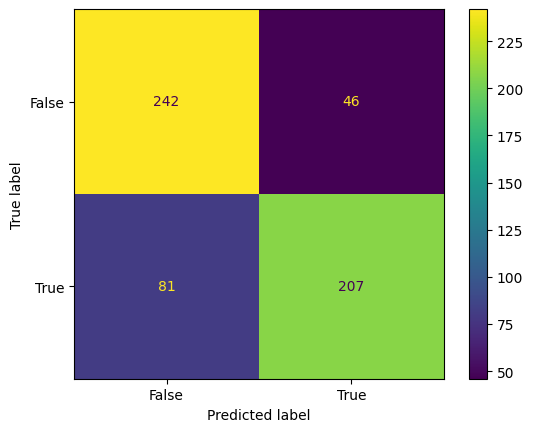

TP: 207.000000

TN: 242.000000

FP: 46.000000

FN: 81.000000

Accuracy: 0.779514

Precision: 0.818182

Sensitivity/Recall: 0.718750

Specificity: 0.840278

F1 score: 0.765250

Matthews Corrcoef:0.563202

0.8403057119871279


In [12]:
#xgboost
model = xgb.XGBClassifier()

param_grid = {
    # Male
    'learning_rate': [0.01,0.05, 0.1],
    'n_estimators': [10,50,100],
    'max_depth': [2,3, 4],
    'subsample': [0.5,0.6,0.7],
    'colsample_bytree': [0.2,0.3,0.4],
    'min_child_weight': [20,30,40],

    # Female
    # 'learning_rate': [0.001, 0.01, 0.1],
    # 'n_estimators': [100,200,300],
    # 'max_depth': [2, 3, 4],
    # 'subsample': [0.6, 0.7, 0.8],
    # 'colsample_bytree': [0.4, 0.5, 0.6],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
evalution_metrics(y_val, y_pred,'xgb')

y_pred_train = best_model.predict(X_train)
print(accuracy_score(y_train, y_pred_train.round()))


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 20, 'n_estimators': 100, 'subsample': 0.7}
Best Score: 0.7627382384760826
Validation Accuracy: 0.7795138888888888
Training Accuracy: 0.8403057119871279


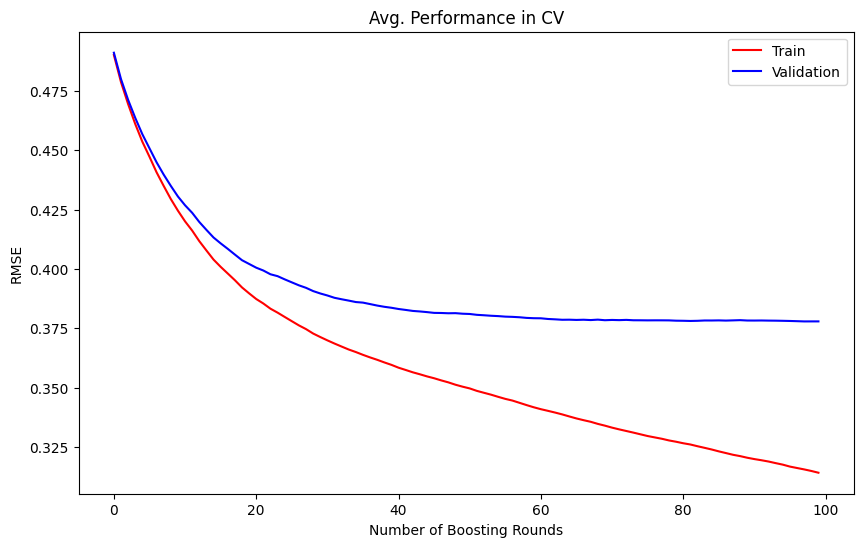

In [13]:
# 調整參數
model = xgb.XGBClassifier()

param_grid = {
    # Male
    'learning_rate': [0.01,0.05, 0.1],
    'n_estimators': [10,50,100],
    'max_depth': [2,3, 4],
    'subsample': [0.5,0.6,0.7],
    'colsample_bytree': [0.2,0.3,0.4],
    'min_child_weight': [20,30,40],

    # Female
    # 'learning_rate': [0.001, 0.01, 0.1],
    # 'n_estimators': [100,200,300],
    # 'max_depth': [2, 3, 4],
    # 'subsample': [0.6, 0.7, 0.8],
    # 'colsample_bytree': [0.4, 0.5, 0.6],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
y_pred_train = best_model.predict(X_train)

accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Validation Accuracy: {accuracy_val}")
print(f"Training Accuracy: {accuracy_train}")

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'learning_rate': best_model.learning_rate,
    'max_depth': best_model.max_depth,
    'subsample': best_model.subsample,
    'colsample_bytree': best_model.colsample_bytree,
}

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=best_model.n_estimators,
    nfold=5,
    metrics={'rmse'},
    as_pandas=True,
    seed=0
)

plt.figure(figsize=(10, 6))
plt.plot(cv_results['train-rmse-mean'], color='red', label='Train')
plt.plot(cv_results['test-rmse-mean'], color='blue', label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Avg. Performance in CV')
plt.legend(loc='upper right')
plt.show()

#### SVM

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'kernel': 'rbf'}
Best Score: 0.6532533896848428


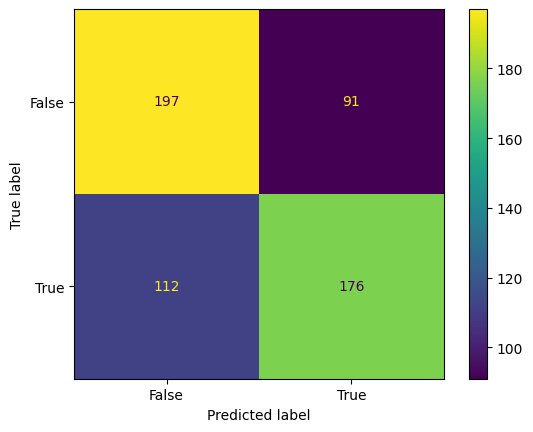

TP: 176.000000

TN: 197.000000

FP: 91.000000

FN: 112.000000

Accuracy: 0.647569

Precision: 0.659176

Sensitivity/Recall: 0.611111

Specificity: 0.684028

F1 score: 0.634234

Matthews Corrcoef:0.295927

0.6767900241351569


In [14]:
#SVM
from sklearn import svm

model = svm.SVC()
param_grid = {
    # Male
    'kernel': ['rbf', 'poly', 'sigmoid']
    # Female
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
evalution_metrics(y_val, y_pred,'svm')

y_pred_train = best_model.predict(X_train)
print(accuracy_score(y_train, y_pred_train.round()))

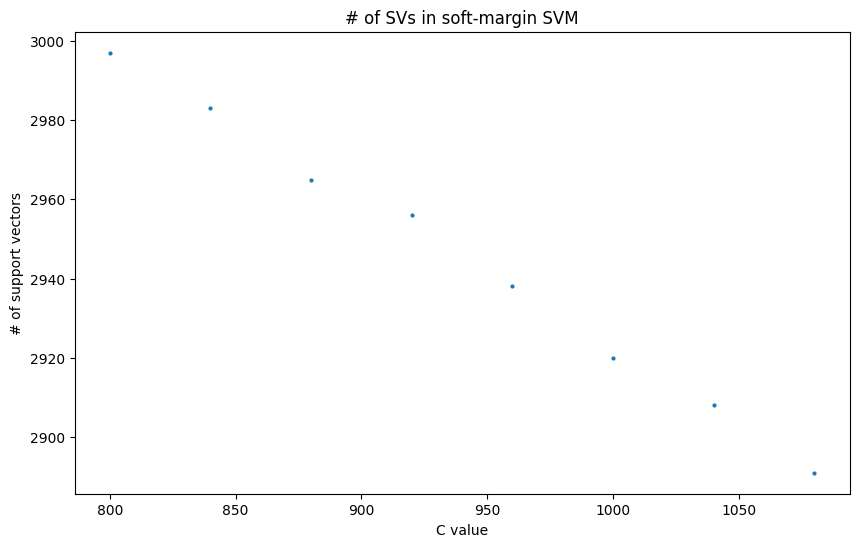

In [15]:
# 隨著C越大，support vectors數量越少，代表margin的範圍越窄，越接近hard-margin SVM，越容易overfitting
C_values = np.arange(800,1101,40)
num_SV = []

for C in C_values:
    model = svm.SVC(C=C)
    model.fit(X_train, y_train)
    num_SV.append(model.support_.size)

plt.figure(figsize=(10, 6))
plt.plot(C_values, num_SV, 'o', markersize=2)
plt.xlabel('C value')
plt.ylabel('# of support vectors')
plt.title('# of SVs in soft-margin SVM')
plt.show()

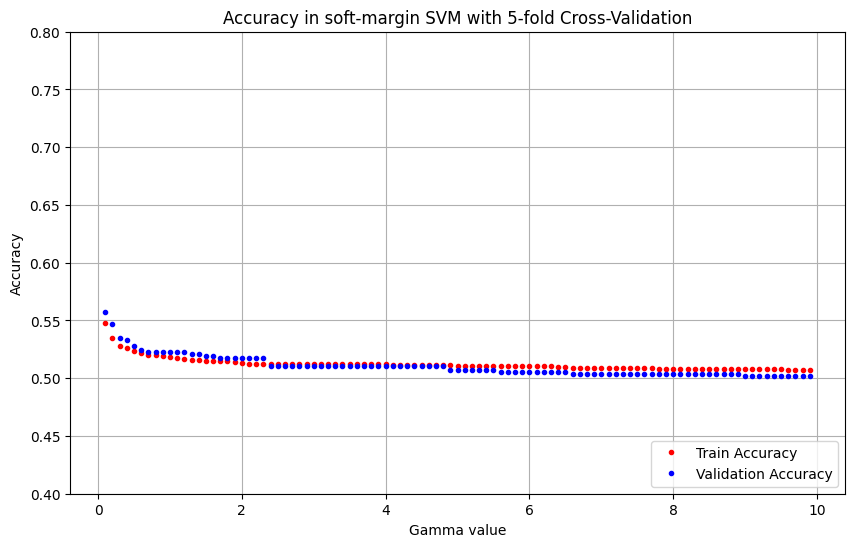

In [16]:
gamma_values = np.arange(0.1, 10, 0.1)
train_accuracy = []
test_accuracy = []

for g in gamma_values:
    model = svm.SVC(gamma=g)

    train_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    train_accuracy.append(np.mean(train_scores))

    test_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='accuracy')
    test_accuracy.append(np.mean(test_scores))

plt.figure(figsize=(10, 6))
plt.plot(gamma_values, train_accuracy, 'o', markersize=3, color='red', label='Train Accuracy')
plt.plot(gamma_values, test_accuracy, 'o', markersize=3, color='blue', label='Validation Accuracy')
plt.xlabel('Gamma value')
plt.ylabel('Accuracy')
plt.title('Accuracy in soft-margin SVM with 5-fold Cross-Validation')
plt.ylim(0.4, 0.8)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### RF

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 200}
Best Score: 0.7641337472068592


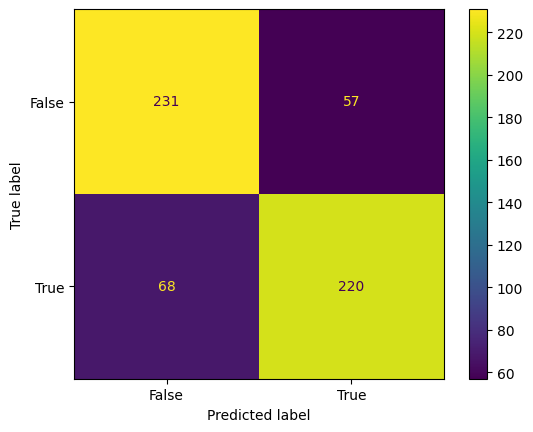

TP: 220.000000

TN: 231.000000

FP: 57.000000

FN: 68.000000

Accuracy: 0.782986

Precision: 0.794224

Sensitivity/Recall: 0.763889

Specificity: 0.802083

F1 score: 0.778761

Matthews Corrcoef:0.566385

0.8415124698310539


In [17]:
#Random forest
model = ensemble.RandomForestClassifier(random_state=42)
param_grid = {
    # Male
    'n_estimators': [100,150,200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [30,40,50],
    'max_features': [5,10,20]

    # Female
    # 'n_estimators': [100,150,200],
    # 'max_depth': [None, 5, 10, 20],
    # 'min_samples_split': [30,40,50],
    # 'min_samples_leaf': [30,40,50],
    # 'max_features': [5,10,20]

}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
evalution_metrics(y_val, y_pred,'rf')

y_pred_train = best_model.predict(X_train)
print(accuracy_score(y_train, y_pred_train.round()))

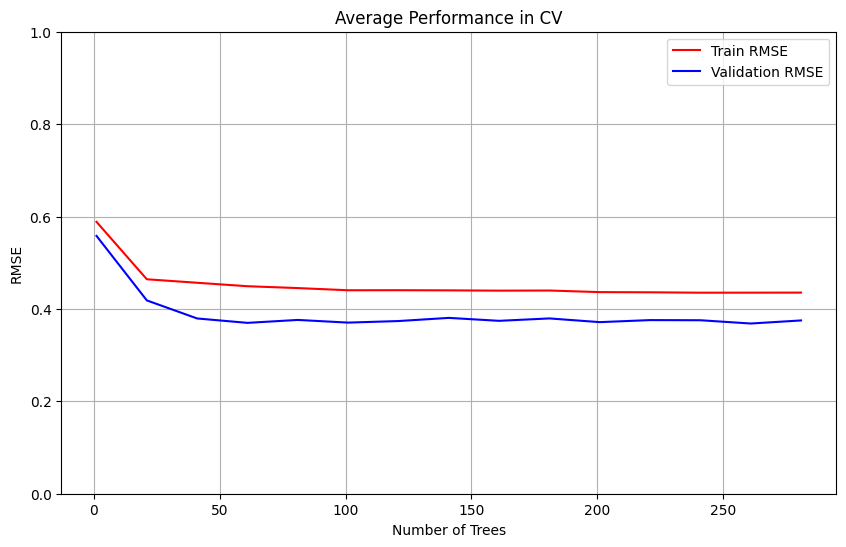

In [18]:
# 增加樹的迭代次數後，觀察模型在訓練集和驗證集上的平均 RMSE，數值越小模型預測越準確
ntree_range = range(1, 301, 20)

train_rmse_mean = []
val_rmse_mean = []

for ntree in ntree_range:
    model = ensemble.RandomForestClassifier(n_estimators=ntree, random_state=42)
    train_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    val_scores = np.sqrt(-cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error'))

    train_rmse_mean.append(np.mean(train_scores))
    val_rmse_mean.append(np.mean(val_scores))

plt.figure(figsize=(10, 6))
plt.plot(ntree_range, train_rmse_mean, color='red', label='Train RMSE')
plt.plot(ntree_range, val_rmse_mean, color='blue', label='Validation RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.ylim(0, 1)
plt.title('Average Performance in CV')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

max_features = 10  OOB error = 0.1979082864038616
max_features = 20  OOB error = 0.19549477071600962
max_features = 30  OOB error = 0.19891391794046664
max_features = 40  OOB error = 0.20454545454545459
max_features = 50  OOB error = 0.20313757039420755


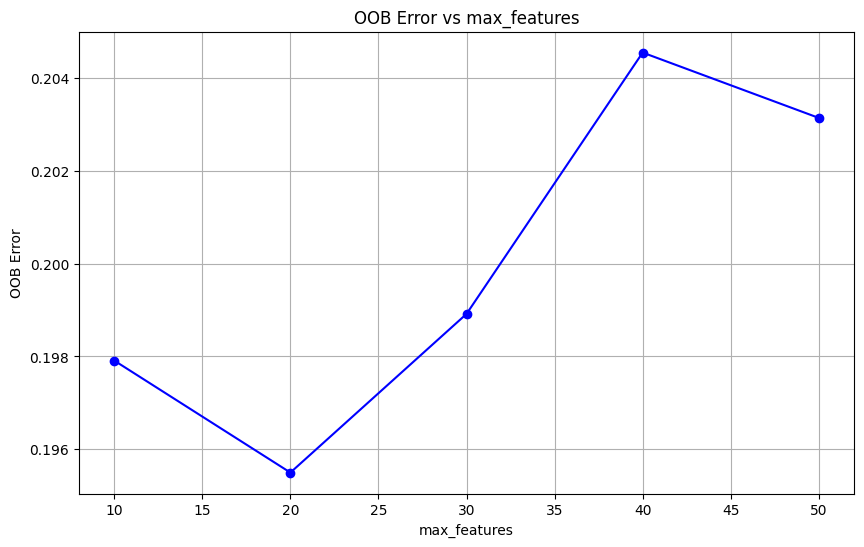

In [19]:
def tune_mtry(X, y, mtry_values):
    results = []

    for mtry in mtry_values:
        model = RandomForestClassifier(max_features=mtry, oob_score=True)
        model.fit(X, y)
        oob_error = 1 - model.oob_score_
        results.append({'mtry': mtry, 'OOBError': oob_error})
        print(f"max_features = {mtry}  OOB error = {oob_error}")

    return pd.DataFrame(results)

mtry_values = [i for i in range(10,51,10)]
results = tune_mtry(X_train, y_train, mtry_values)

plt.figure(figsize=(10, 6))
plt.plot(results['mtry'], results['OOBError'], marker='o', linestyle='-', color='b')
plt.xlabel('max_features')
plt.ylabel('OOB Error')
plt.title('OOB Error vs max_features')
plt.grid(True)
plt.show()

#### DT

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 5, 'max_features': 30, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best Score: 0.6993504747075417


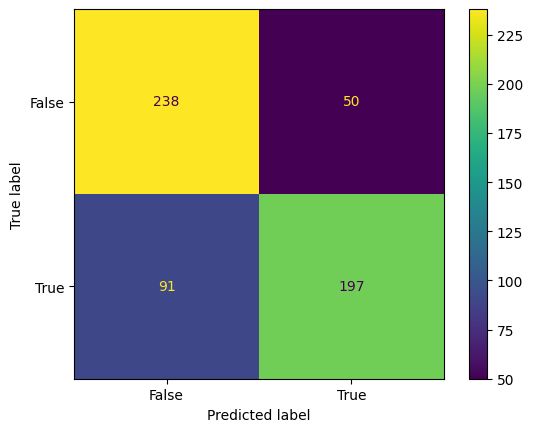

TP: 197.000000

TN: 238.000000

FP: 50.000000

FN: 91.000000

Accuracy: 0.755208

Precision: 0.797571

Sensitivity/Recall: 0.684028

Specificity: 0.826389

F1 score: 0.736449

Matthews Corrcoef:0.515669

0.7276749798873693


In [20]:
#Decisiontree
model=DecisionTreeClassifier(random_state=42)

param_grid = {
    # Male
    'max_depth': [3,4,5],
    'min_samples_split': [5, 10, 20,30],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [10,20,30]

    #Female
    # 'max_depth': [6,7,8,9,10],
    # 'max_features': [30,35,40]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
evalution_metrics(y_val, y_pred,'dt')

y_pred_train = best_model.predict(X_train)
print(accuracy_score(y_train, y_pred_train.round()))